In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from graph.structure.graph import Graph
from graph.prior.sparse_prior import SparsePrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.masked_gaussian_measurement import MaskedGaussianMeasurement
from core.metrics import mse
from core.linalg_utils import random_binary_mask

In [8]:
# ==== 1. パラメータ設定 ====
H, W = 128,128
rho = 0.1
var = 1e-4
mask_ratio = 0.2
rng = np.random.default_rng(seed=42)

# ==== 2. モデル定義（Prior → FFT2D → MaskedGaussian） ====
class FFT2DTestGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(H, W))
        self.Y = FFT2DPropagator(shape=(H, W)) @ self.X
        mask = random_binary_mask((H, W), subsampling_rate=mask_ratio, rng=rng)
        self.Z = MaskedGaussianMeasurement(self.Y, var=var, mask=mask)
        self.compile()

In [9]:
# ==== 3. グラフ構築 ====
g = FFT2DTestGraph()

# ==== 4. サンプル生成 ====
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=99))

true_x = g.X.get_sample()
observed = g.Z.get_sample()

In [10]:
# ==== 5. 推論実行 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

# ==== 6. 結果表示 ====
final_est = g.X.compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

[t=0] MSE = 3.85343e-01
[t=5] MSE = 4.07597e-02
[t=10] MSE = 1.27936e-02
[t=15] MSE = 1.72725e-03
[t=20] MSE = 1.75665e-04
[t=25] MSE = 9.77017e-05
Final MSE after 30 iterations: 9.39765e-05


In [11]:
%prun -l 30 -s cumulative g.run(n_iter=30, callback=monitor)

[t=0] MSE = 9.39146e-05
[t=5] MSE = 9.37539e-05
[t=10] MSE = 9.37763e-05
[t=15] MSE = 9.37790e-05
[t=20] MSE = 9.37789e-05
[t=25] MSE = 9.37789e-05
 

         11611 function calls in 0.101 seconds

   Ordered by: cumulative time
   List reduced from 145 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.101    0.101 {built-in method builtins.exec}
        1    0.000    0.000    0.101    0.101 <string>:1(<module>)
        1    0.000    0.000    0.101    0.101 graph.py:58(run)
       30    0.000    0.000    0.038    0.001 graph.py:48(forward)
       30    0.000    0.000    0.034    0.001 82646459.py:2(monitor)
       30    0.000    0.000    0.030    0.001 sparse_prior.py:33(forward)
       30    0.000    0.000    0.030    0.001 sparse_prior.py:17(_compute_message)
       30    0.000    0.000    0.030    0.001 wave.py:62(compute_belief)
       30    0.002    0.000    0.029    0.001 uncertain_array.py:131(combine)
       30    0.000    0.000    0.029    0.001 graph.py:53(backward)
       30    0.000    0.000    0.029    0.001 fft_2d_propagator.py:105(ba

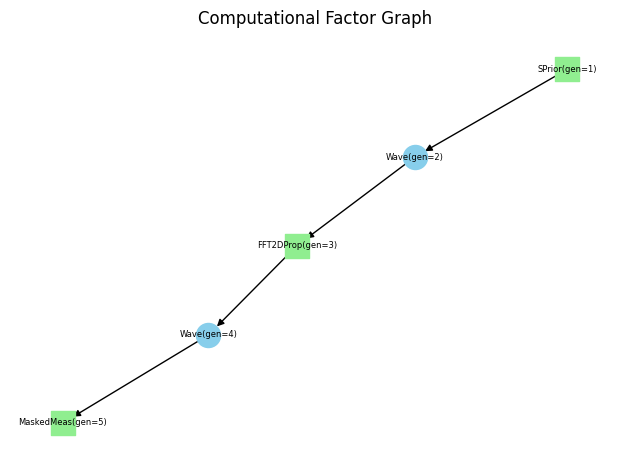

In [7]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)